In [1]:
from bubblewrap import Bubblewrap
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Generate some data

In [2]:
%env TF_CPP_MIN_LOG_LEVEL=0
%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.05

env: TF_CPP_MIN_LOG_LEVEL=0
env: XLA_PYTHON_CLIENT_MEM_FRACTION=0.05


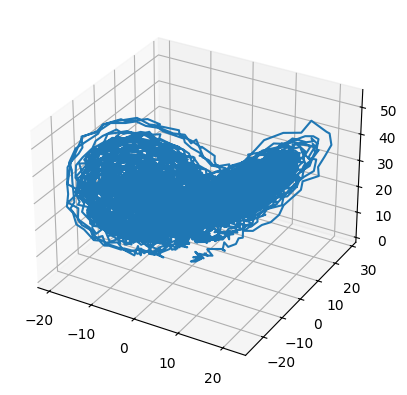

In [4]:
generator = np.random.default_rng()

def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])


dt = 0.01
num_steps = 10000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

sigma1 = 0.75#*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
sigma2 = 1.5#*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
noise = sigma1 *generator.normal(size=xyzs.shape)


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
#ax.plot(xyzs[:,0],xyzs[:,1],xyzs[:,2],linewidth=0.5)
ax.plot(xyzs[:,0]+noise[:,0],xyzs[:,1]+noise[:,1],xyzs[:,2]+noise[:,2])#,alpha=0.25)
plt.show()
plt.close()

In [5]:
def generate_radial_odes(n=100,T=1,dt=0.001,
                        coeffs=[1.5,2,np.pi/4],sigma=0.,
                        seed=1040):
    """
    Makes the circles dataset (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles),
    but as a dynamical system, but with a double well potential on the radius 
    Takes as arguments:
    n: number of trajectories to make
    T: integration time
    dt: integration timestep
    coeffs:
        center of double well, weight on quadratic term, rotation per second, weight on dR

    Returns:
    trajectories:
    list of n np.ndarrays of size (T/dt)x2, each element corresponding to a trajectory
    """    

    trajectories=[]
    t = np.arange(0,T,dt)
    gen = np.random.default_rng(seed=seed)
    
    r0,a,omega = coeffs

    def ft(theta,t,omega):
        #dtheta = omega
        return omega
    
    def fr(r,t):
        
        # potential function: (r - r0)^4 - a(r - r0)^2
        return -(4 * (r - r0)**3 - 2*a * (r - r0))

    def g(x,t):
        return sigma*np.eye(2)

    def dW(dt):
        return gen.multivariate_normal(mean=np.zeros((2,)),cov = dt*np.eye(2))


    for ii in range(n):

        rnot = r0 #+ gen.uniform(-r0/10,r0/10)
        thetanot = gen.uniform(0,2*np.pi)
        xnot = np.array([rnot*np.cos(thetanot),rnot*np.sin(thetanot)])#gen.multivariate_normal(mean=np.zeros((2,)),cov = a*np.eye(2))
     
        theta = np.arctan2(xnot[1],xnot[0])
        r = np.linalg.norm(xnot)
        xx = [xnot]
        for jj in range(1,len(t)+1):
            x = xx[jj-1]
            tt = t[jj-1]
            if r < r0:
                dtheta = ft(theta,tt,omega)
            else:
                dtheta = ft(theta,tt,-omega)
            dr = fr(r,tt)
            theta += dtheta*dt
            r += dr*dt
            r = max(0,r)
            xy = np.array([r*np.cos(theta),r*np.sin(theta)])
            dw_xy = g(xy,tt) @ dW(dt)
            xy2 = xy + dw_xy

            theta = np.arctan2(xy2[1],xy2[0])
            r = np.linalg.norm(xy2)
            xx2 = np.hstack(xy2)
            xx.append(xx2)
        xx = np.vstack(xx)

        trajectories.append(xx)


    return trajectories

In [28]:
r0,a,omega= 4,10,2*np.pi

dt1 = 0.001
dt2 = dt1 * (55401/8346)
radial1 = generate_radial_odes(n=100,T=1,dt=dt1,
                        coeffs=[r0,a,omega],sigma=2,
                        seed=1040)
radial2 = generate_radial_odes(n=100,T=1,dt=dt2,
                        coeffs=[r0,a,omega],sigma=0.1,
                        seed=1040)

stacked1 = np.vstack(radial1)
stacked2 = np.vstack(radial2)



In [29]:
print(dt2)

0.00663803019410496


(100100, 2)
(15200, 2)
initializing using kmeans


fitting bubblewrap...: 100%|███████████████████████| 1/1 [00:41<00:00, 41.37s/it]


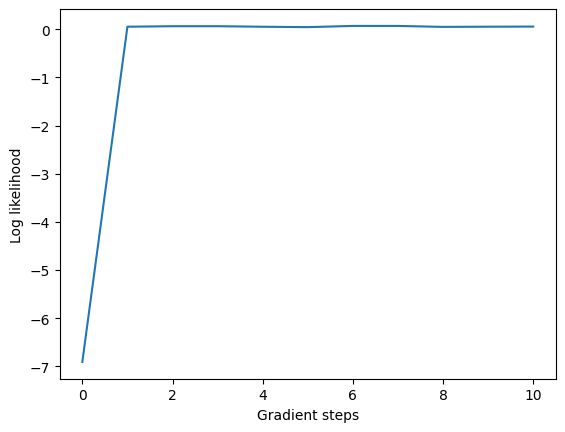

initializing using kmeans


fitting bubblewrap...: 100%|███████████████████████| 1/1 [00:06<00:00,  6.26s/it]


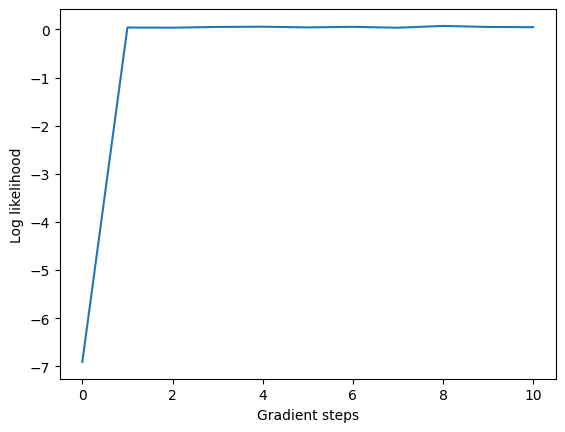

2.9644163 3.3363872


In [46]:
print(stacked1.shape)
print(stacked2.shape)
bw1 = bubblewrap_data(stacked1,50,n_passes=1,step=1e-3)
bw2 = bubblewrap_data(stacked2,50,n_passes=1,step=1e-3)
#bw3 = bubblewrap_data(samples_gm2_dense,3)

bound1 = bw1.get_fisher_ub()
bound2 = bw2.get_fisher_ub()
print(bound1,bound2)


In [42]:
from bubblewrap import get_fullSigma
from jax import jit, vmap
from jax import numpy as jnp

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

get_sigma_jax = jit(vmap(get_fullSigma))

def pearson(cov):
    return cov[0,1]/jnp.sqrt(cov[0,0]*cov[1,1])
pearson_jax = jit(vmap(pearson))

def plot_means_covars(model,axis,color='tab:blue'):

    means,covs = model.mu,get_sigma_jax(model.L)
    ps = pearson_jax(covs)
    print(ps.shape)
    ell_rad_x = np.sqrt(1 + ps)
    ell_rad_y = np.sqrt(1 - ps)
    print(ell_rad_x.shape)
    print(means.shape)
    scale_x = np.sqrt(covs[:,0,0])
    scale_y = np.sqrt(covs[:,1,1])

    for ii,(m,rx,ry,sx,sy) in enumerate(zip(means,ell_rad_x,ell_rad_y,scale_x,scale_y)):
        if model.alpha[ii] > 0:
            ellipse = Ellipse((0,0),width=rx*2,height=ry*2,facecolor='none',edgecolor=color)
            transf = transforms.Affine2D() \
            .rotate_deg(0) \
            .scale(sx,sy) \
            .translate(m[0],m[1])
    
            ellipse.set_transform(transf + ax.transData)
            ax.add_patch(ellipse)
        else:
            print(ii)

    return means,ps


m,c = plot_means_covars(bw1,2)

(25,)
(25,)
(25, 2)


In [43]:
print(c)

[-0.00479969  0.00565058 -0.00797933 -0.00797658  0.00788843  0.00802083
  0.00254358  0.00800307 -0.00730817  0.00804909 -0.00799379 -0.00801908
 -0.00781802 -0.00794146 -0.00803799 -0.00792671  0.00804505 -0.00799103
  0.00784501  0.00425988 -0.00804607  0.00800693  0.00802668 -0.00813727
  0.00795194]


In [44]:
#print(bw1.mu)
print(get_sigma_jax(bw1.L))
#print(bw1.alpha)
#print(bw1.B)

[[[ 1.3435876  -0.00647584]
  [-0.00647584  1.3548775 ]]

 [[ 1.3398985   0.00761363]
  [ 0.00761363  1.3549538 ]]

 [[ 1.3396425  -0.01075026]
  [-0.01075026  1.3549277 ]]

 [[ 1.3395971  -0.01074657]
  [-0.01074657  1.354978  ]]

 [[ 1.3395555   0.01063574]
  [ 0.01063574  1.3570455 ]]

 [[ 1.3397557   0.01080665]
  [ 0.01080665  1.3549316 ]]

 [[ 1.3396465   0.0034275 ]
  [ 0.0034275   1.3554243 ]]

 [[ 1.3398353   0.01078277]
  [ 0.01078277  1.354865  ]]

 [[ 1.3396077  -0.00984552]
  [-0.00984552  1.354822  ]]

 [[ 1.3395187   0.01084418]
  [ 0.01084418  1.3550363 ]]

 [[ 1.3402004  -0.01077166]
  [-0.01077166  1.354847  ]]

 [[ 1.3395854  -0.01080995]
  [-0.01080995  1.3565265 ]]

 [[ 1.3401203  -0.01053466]
  [-0.01053466  1.3548908 ]]

 [[ 1.3395689  -0.01069908]
  [-0.01069908  1.3549608 ]]

 [[ 1.3397295  -0.01083009]
  [-0.01083009  1.3550396 ]]

 [[ 1.3397897  -0.01067999]
  [-0.01067999  1.354936  ]]

 [[ 1.3397547   0.01083938]
  [ 0.01083938  1.3549585 ]]

 [[ 1.3397385 

(50,)
(50,)
(50, 2)
(50,)
(50,)
(50, 2)
0
13
15
24
34
38
48
49


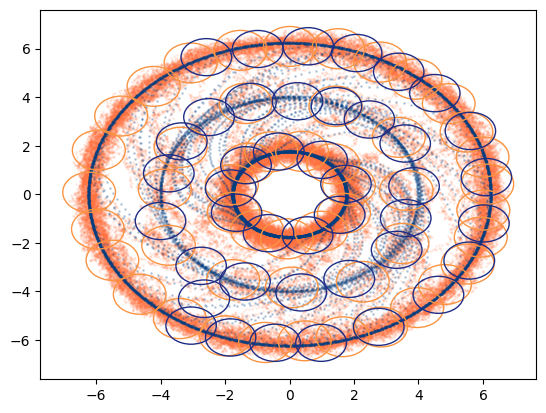

In [47]:
ax = plt.gca()
ax.scatter(stacked1[:,0],stacked1[:,1],alpha=0.1,s=1,color='#FF7340')
ax.scatter(stacked2[:,0],stacked2[:,1],alpha=0.2,s=1,color='#003E83')
plot_means_covars(bw1,ax,color='#FA9442')
plot_means_covars(bw2,ax,color='#202D85')

plt.show()
plt.close()

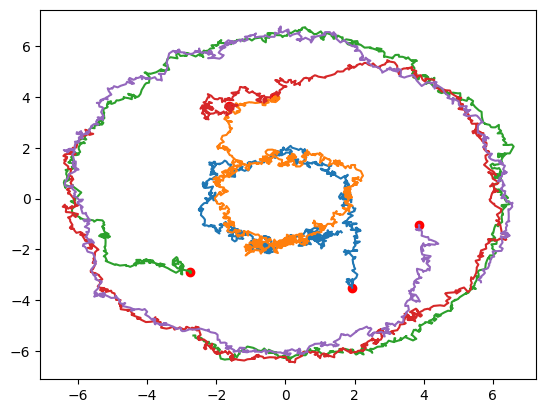

In [22]:
ax = plt.gca()
for ii in radial1[:5]:
    ax.scatter(ii[0,0],ii[0,1],color='r')
    ax.plot(ii[:,0],ii[:,1])

plt.show()
plt.close()

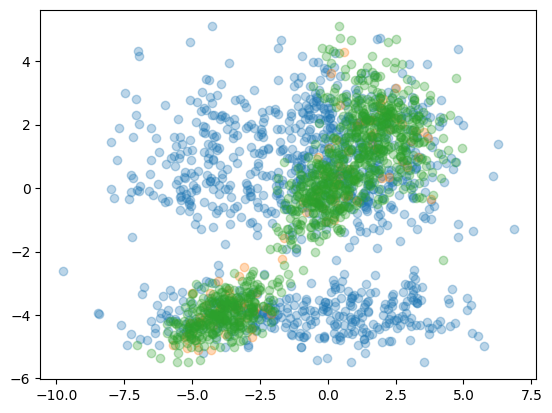

In [31]:
def sample_gaussian_mixture(n_samples,weights,mus,covars,generator):

    samples = np.zeros((n_samples,mus.shape[-1]))
    
    for ii in range(n_samples):

        gauss = generator.choice(len(weights),1,p=weights).squeeze()
        
        mean = mus[gauss,]
        cov = covars[gauss]
        samples[ii] = generator.multivariate_normal(mean=mus[gauss],cov=covars[gauss])
        
    return samples

gen = np.random.default_rng()

mu1,cov1 = np.array([0,0]),np.array([[2,1],[1,2]])
mu2,cov2 = np.array([2,2]),np.array([[3,-1],[-1,3]])
mu3,cov3 = np.array([-4,-4]),np.array([[3,1],[1,1]])

weights1 = np.array([0.33,0.33,0.33])
weights1 /= np.sum(weights1)
weights2 = np.array([0.1,0.1,0.8])

samples_gm1_dense = sample_gaussian_mixture(1000,weights1,np.vstack([mu1,mu2,mu3]),np.stack([cov1,cov2,cov3]),gen)
samples_gm1_sparse = sample_gaussian_mixture(300,weights1,np.vstack([mu1,mu2,mu3]),np.stack([cov1,cov2,cov3]),gen)
samples_gm2_dense = sample_gaussian_mixture(1000,weights1,np.vstack([mu1,mu2,mu3]),np.stack([cov1/3,cov2/3,cov3/3]),gen)
samples_gm2_sparse = sample_gaussian_mixture(100,weights1,np.vstack([mu1,mu2,mu3]),np.stack([cov1/3,cov2/3,cov3/3]),gen)

ax = plt.gca()

ax.scatter(samples_gm1_dense[:,0],samples_gm2_dense[:,1],alpha=0.3)
ax.scatter(samples_gm2_sparse[:,0],samples_gm2_sparse[:,1],alpha=0.3)
ax.scatter(samples_gm2_dense[:,0],samples_gm2_dense[:,1],alpha=0.3)
plt.show()
plt.close()

In [32]:
bw1 = bubblewrap_data(samples_gm1_dense,3)
bw2 = bubblewrap_data(samples_gm2_sparse,3)
bw3 = bubblewrap_data(samples_gm2_dense,3)

bound1 = bw1.get_fisher_ub()
bound2 = bw2.get_fisher_ub()
bound3 = bw3.get_fisher_ub()


In [33]:
print(bound1)
print(bound2)
print(bound3)

0.47528172
0.51335967
0.5304727


In [7]:
from jax import jit

def bubblewrap_data(data,n,n_passes,step=1,eps=1e-3,nu=1e-3,lam=1e-3):
    
    N = n             # number of nodes to tile with
    lam = lam          # lambda 
    nu = nu           # nu
    eps = eps          # epsilon sets data forgetting
    step = step        # for adam gradients
    
    B_thresh = -10      # threshold for when to teleport (log scale)    
    batch = True       # run in batch mode 
    
    go_fast = True     # flag to skip computing priors, predictions, and entropy for optimal speed
    future_distance = 1

    T = data.shape[0]      
    d = data.shape[1]       # should be 3

    M = T//10              # small set of data seen for initialization
    batch_size = T//10      # batch mode size; if not batch is 1

    ll = []
    bw = Bubblewrap(N, d, step=step, lam=lam, M=M, eps=eps, nu=nu, B_thresh=B_thresh, batch=batch, batch_size=batch_size, go_fast=go_fast, future_distance=future_distance)

    #print('initializing bubblewrap...')
    step = batch_size
    order = np.random.choice(len(data),len(data),replace=False)
    ordered_data = data[order]
    for i in np.arange(0, M, step): 
        bw.observe(ordered_data[i:i+step])
    bw.init_nodes()
    ll.append(bw.log_pred_prob(bw.B,bw.A,bw.alpha))
    #print(f"{np.sum(np.isnan(bw.L))} nan values in L")
    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for p in tqdm(range(n_passes),desc='fitting bubblewrap...'):
        order = np.random.choice(len(data),len(data),replace=False)
        ordered_data = data[order]
        for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
            future_index = i+M+step - 2 + bw.future_distance
            future_x = ordered_data[future_index] if future_index < ((end- 1) + M ) else None
        
            bw.observe(ordered_data[i+M:i+M+step], future_x=future_x)
            bw.e_step()  
            bw.grad_Q()
            ll.append(bw.log_pred_prob(bw.B,bw.A,bw.alpha))
            nNan = np.sum(np.isnan(bw.L))
            if nNan > 0:
                print(f"after iter {i+1}, {nNan} nans in L")

    ax = plt.gca()
    ax.plot(ll)
    ax.set_xlabel("Gradient steps")
    ax.set_ylabel("Log likelihood")
    plt.show()
    plt.close()
    return bw

def update_bubblewrap(bw,data):

    T = data.shape[0]      
    d = data.shape[1]
    M = T//100              # small set of data seen for initialization
    batch_size = T//100      # batch mode size; if not batch is 1

    init = -M
    end = T-M
    step = batch_size

    #print('fitting bubblewrap....')
    for i in np.arange(init, end, step): #,desc='fitting bubblewrap....'):
        future_index = i+M+step - 2 + bw.future_distance
        future_x = data[future_index] if future_index < ((end- 1) + M ) else None
    
        bw.observe(data[i+M:i+M+step], future_x=future_x)
        bw.e_step()  
        bw.grad_Q(mode='update')
        nNan = np.sum(np.isnan(bw.L))
        if nNan > 0:
            print(f"after iter {i+1}, {nNan} nans in L")

    return bw
    

    

In [12]:
nIters = 50
bw = bubblewrap_data(xyzs)
bound_noiseless = bw.get_fisher_ub()
print(bound_noiseless)

6.706532


In [13]:
bounds_noisy = []
for noiseLevel in np.arange(0.25,10.3,1.):
    print(f"Noise level: {noiseLevel}")
    sigma = noiseLevel#*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
    noiseBounds = []
    for iter in tqdm(range(nIters),desc = f"simulating for noise sd: {noiseLevel}"):
        #print(iter,end=", ")
        noise = sigma *generator.normal(size=xyzs.shape)
        bwNoise = bubblewrap_data(xyzs + noise)
        noiseBounds.append(bwNoise.get_fisher_ub())
    bounds_noisy.append(noiseBounds)

Noise level: 0.25


simulating for noise sd: 0.25: 100%|██████████████████████████████████| 50/50 [04:46<00:00,  5.74s/it]


Noise level: 1.25


simulating for noise sd: 1.25: 100%|██████████████████████████████████| 50/50 [04:50<00:00,  5.82s/it]


Noise level: 2.25


simulating for noise sd: 2.25: 100%|██████████████████████████████████| 50/50 [04:45<00:00,  5.71s/it]


Noise level: 3.25


simulating for noise sd: 3.25: 100%|██████████████████████████████████| 50/50 [04:46<00:00,  5.73s/it]


Noise level: 4.25


simulating for noise sd: 4.25: 100%|██████████████████████████████████| 50/50 [04:31<00:00,  5.43s/it]


Noise level: 5.25


simulating for noise sd: 5.25: 100%|██████████████████████████████████| 50/50 [04:33<00:00,  5.48s/it]


Noise level: 6.25


simulating for noise sd: 6.25: 100%|██████████████████████████████████| 50/50 [04:38<00:00,  5.57s/it]


Noise level: 7.25


simulating for noise sd: 7.25: 100%|██████████████████████████████████| 50/50 [04:39<00:00,  5.60s/it]


Noise level: 8.25


simulating for noise sd: 8.25: 100%|██████████████████████████████████| 50/50 [04:35<00:00,  5.52s/it]


Noise level: 9.25


simulating for noise sd: 9.25: 100%|██████████████████████████████████| 50/50 [04:38<00:00,  5.58s/it]


Noise level: 10.25


simulating for noise sd: 10.25: 100%|█████████████████████████████████| 50/50 [04:40<00:00,  5.61s/it]


In [14]:
bounds_noisy_cos = []
for noiseLevel in np.arange(0.25,10.3,1.):
    print(f"Noise level: {noiseLevel}")
    sigma = noiseLevel*np.cos(np.linspace(0,1,len(xyzs))*10*np.pi)[:,None]
    noiseBounds = []
    for iter in tqdm(range(nIters),desc = f"simulating for noise sd: {noiseLevel}"):
        #print(iter,end=", ")
        noise = sigma *generator.normal(size=xyzs.shape)
        bwNoise = bubblewrap_data(xyzs + noise)
        noiseBounds.append(bwNoise.get_fisher_ub())
    bounds_noisy_cos.append(noiseBounds)

Noise level: 0.25


simulating for noise sd: 0.25: 100%|██████████████████████████████████| 50/50 [04:26<00:00,  5.34s/it]


Noise level: 1.25


simulating for noise sd: 1.25: 100%|██████████████████████████████████| 50/50 [04:28<00:00,  5.36s/it]


Noise level: 2.25


simulating for noise sd: 2.25: 100%|██████████████████████████████████| 50/50 [04:30<00:00,  5.41s/it]


Noise level: 3.25


simulating for noise sd: 3.25: 100%|██████████████████████████████████| 50/50 [04:31<00:00,  5.43s/it]


Noise level: 4.25


simulating for noise sd: 4.25: 100%|██████████████████████████████████| 50/50 [04:31<00:00,  5.44s/it]


Noise level: 5.25


simulating for noise sd: 5.25: 100%|██████████████████████████████████| 50/50 [04:33<00:00,  5.48s/it]


Noise level: 6.25


simulating for noise sd: 6.25: 100%|██████████████████████████████████| 50/50 [04:34<00:00,  5.49s/it]


Noise level: 7.25


simulating for noise sd: 7.25: 100%|██████████████████████████████████| 50/50 [04:35<00:00,  5.52s/it]


Noise level: 8.25


simulating for noise sd: 8.25: 100%|██████████████████████████████████| 50/50 [04:36<00:00,  5.53s/it]


Noise level: 9.25


simulating for noise sd: 9.25: 100%|██████████████████████████████████| 50/50 [04:37<00:00,  5.55s/it]


Noise level: 10.25


simulating for noise sd: 10.25: 100%|█████████████████████████████████| 50/50 [04:37<00:00,  5.56s/it]


In [15]:
#bounds_noisy = [[b.get_fisher_ub() for b in bws] for bws in bwNoises]
#print(bounds_noisy)
muBs = [np.nanmean(b) for b in bounds_noisy]
seBs = [np.nanstd(b)/len(b) for b in bounds_noisy]
muBsC = [np.nanmean(b) for b in bounds_noisy_cos]
seBsC = [np.nanstd(b)/len(b) for b in bounds_noisy_cos]

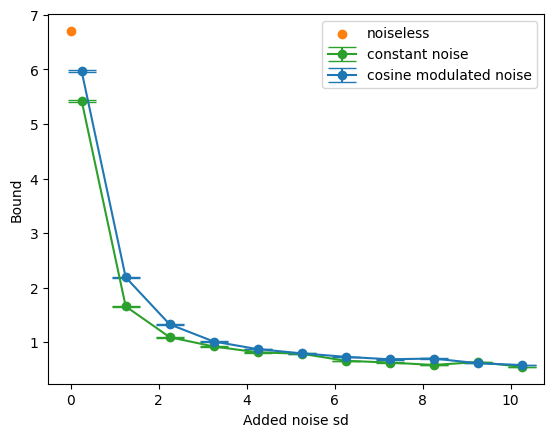

In [16]:
ax = plt.gca()
ax.scatter([0],[bound_noiseless],color='tab:orange',label='noiseless')
ax.errorbar(np.arange(0.25,10.3,1.),muBs,yerr=seBs,fmt='-o',capsize=10,color='tab:green',label='constant noise')
ax.errorbar(np.arange(0.25,10.3,1.),muBsC,yerr=seBsC,fmt='-o',capsize=10,color='tab:blue',label='cosine modulated noise')
ax.set_xlabel("Added noise sd")
ax.set_ylabel("Bound")
#ax.set_title("Constant noise")
plt.legend()
plt.savefig("./boundByAddedNoises_samemeans.png")
plt.show()
plt.close()